# Illustration of Fisher's combination method

We'll set up a hypothetical election and a single sample of ballots to illustrate how to combine a ballot-polling audit with a ballot-comparison audit using Fisher's combining function.

There are two strata. One contains every CVR county and the other contains every no-CVR county.
There were 11,000 ballots cast in the election, 10,000 in the CVR stratum and 1,000 in the no-CVR stratum.

In the CVR stratum, there were 4,550 votes reported for A, 4,950 votes for candidate B, and 500 invalid ballots.
In the no-CVR stratum, there were 750 votes reported for A, 150 votes for B, and 100 invalid ballots.
A won overall, with 5,300 votes to B's 5,1000, but not in the CVR stratum.
The reported vote margin between A and B is 200 votes, a "diluted margin" of $200/11,000 = 1.8\%$.


Candidate | Stratum 1 | Stratum 2 | total 
---|---|---|---
A | 4,550 | 750 | 5,300
B | 4,950 | 150 | 5,100
Ballots | 10,000 | 1,000 | 11,000
Diluted margin | -4% | 60% | 1.8%

We want to limit the risk of certifying an incorrect outcome to at most $\alpha=10\%$. 

In the CVR stratum, we sample 500 ballots and find no discrepancies.

In the no-CVR stratum, we sample 250 ballots. We are unusually lucky and the vote proportions in the sample match those in the population. There are $187$ ballots for A and $37$ ballots for B. 

In [1]:
import numpy as np
import scipy as sp
import scipy.stats
import scipy.optimize
from ballot_comparison import ballot_comparison_pvalue
from fishers_combination import fisher_combined_pvalue, maximize_fisher_combined_pvalue, \
    calculate_lambda_range, create_modulus

    
from sprt import ballot_polling_sprt

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
N1 = 10000
N2 = 1000
N_w1 = 4550
N_l1 = 4950
N_w2 = 750
N_l2= 150
margin = (N_w1 + N_w2 - N_l1 - N_l2)

n1 = 500
n2 = 250

Below, we define functions for computing $P$-values based on the observed samples. 
The observed statistics and known parameters (e.g. the total number of ballots cast in each stratum) should be plugged in already. These $P$-values are functions of the error allocation $\lambda$ which determines how much overstatement error is allowed in each stratum.

In [3]:
cvr_pvalue = lambda alloc: \
    ballot_comparison_pvalue(n=n1, gamma=1.03905, o1=0, u1=0, o2=0, u2=0, \
                             reported_margin=margin, N=N1, null_lambda=alloc)

nocvr_pvalue = lambda alloc: \
    ballot_polling_sprt(sample= np.array([0]*int(n2*N_l2/N2)+\
                                             [1]*int(n2*N_w2/N2)+\
                                             [np.nan]*int(n2*(N2-N_l2-N_w2)/N2 + 1)), \
                            popsize=N2, \
                            alpha=0.05,  # set this param but we don't need to use it
                            Vw=N_w2, \
                            Vl=N_l2, \
                            null_margin=(N_w2-N_l2) - alloc*margin)['pvalue']

In [4]:
# This is one possible allocation lambda=0.3

print("lambda = 0.3")
pvalues = [cvr_pvalue(0.3), nocvr_pvalue(0.7)]
print("CVR P-value:", pvalues[0], "\nno-CVR P-value:", pvalues[1])
fisher_pvalue = fisher_combined_pvalue(pvalues)
print("Fisher's combined P-value:", fisher_pvalue)

lambda = 0.3
CVR P-value: 0.23557770396261943 
no-CVR P-value: 0.006068185147942991
Fisher's combined P-value: 0.010793531242678012


# Maximizing the $P$-value over $\lambda$

We can stop the audit if the $P$-value is less than the risk limit, $10\%$, for all values of $\lambda$ that allocating the overstatement error between the CVR and no-CVR strata. First, let's just plot the $P$-values in each stratum for varying values of $\lambda$ to see how they behave.

Lambda limits: -7.0 3.0


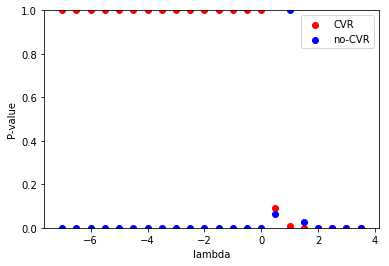

In [5]:
# find range of possible lambda
(lambda_lower, lambda_upper) = calculate_lambda_range(N_w1, N_l1, N1, N_w2, N_l2, N2)

print("Lambda limits:", lambda_lower, lambda_upper)

fisher_pvalues = []
cvr_pvalues = []
nocvr_pvalues = []
for lam in np.arange(lambda_lower, lambda_upper+1, 0.5):
    cvr_pvalues.append(np.min([1, cvr_pvalue(lam)]))
    nocvr_pvalues.append(nocvr_pvalue(1-lam))
    fisher_pvalues.append(fisher_combined_pvalue([cvr_pvalues[-1], nocvr_pvalues[-1]]))
    
plt.scatter(np.arange(lambda_lower, lambda_upper+1, 0.5), cvr_pvalues, color='r', label="CVR")
plt.scatter(np.arange(lambda_lower, lambda_upper+1, 0.5), nocvr_pvalues, color='b', label="no-CVR")
plt.legend()
plt.xlabel("lambda")
plt.ylabel("P-value")
plt.ylim(0, 1)
plt.show()



When one $P$-value is large, the other is small. Below we plot the Fisher's combined $P$-value. It is small whenever *at least* one of the CVR and no-CVR $P$-values is small.

The Fisher's combined $P$-value peaks between $\lambda = 0$ and $2$. But this plot just shows us the maximum along a grid. Below, we use the function `maximize_fisher_combined_pvalue` to find the maximum on a further refined grid. It's just over $7\%$, higher than what the points on the grid show. We'd need to increase the sample sizes in each stratum to attain a 5\% risk limit.

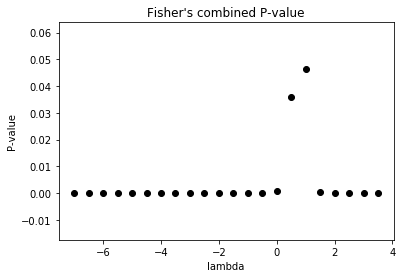

In [6]:
plt.scatter(np.arange(lambda_lower, lambda_upper+1, 0.5), fisher_pvalues, color='black')
plt.title("Fisher's combined P-value")
plt.xlabel("lambda")
plt.ylabel("P-value")
plt.show()

In [7]:
mod = create_modulus(n1=n1, n2=n2, n_w2=int(n2*N_w2/N2), n_l2=int(n2*N_l2/N2), 
                     N1=N1, V_wl=margin, gamma=1.03905)

In [8]:
maximize_fisher_combined_pvalue(N_w1, N_l1, N1, N_w2, N_l2, N2,
                                pvalue_funs = (cvr_pvalue, nocvr_pvalue), 
                                stepsize=0.05, modulus=mod, alpha=0.05)

{'max_pvalue': 0.07049896663377597,
 'min_chisq': 8.648940992563045,
 'allocation lambda': 0.7999999999999723,
 'tol': None,
 'stepsize': 0.05,
 'refined': False}